# Data Scientist Nanodegree Capstone Project
#### By Clayton Van Hovel

## Goal 
##### 1.) Investigate event data from a music streaming service and predict when a user is going to cancel their account
##### 2.) Use Spark ML to process and model the data  

## Overview
* Process data
* Visualize some intuitions
* Create features
* Implement classification algorithms
* Tune models
* Evaluate trained models

## Data
The data was provided by Udacity and intended to simulate logs from a music streaming website such as Spotify or Pandora

## Churn
In this situation churn is defined as the event when a user cancels their acccount

## Feature Engineering
From the log data I created a dataframe with one row for each user and the following features 
* Status ( Paid or Free )
* Days since registration
* Number of "Thumbs Up" given
* Variety of artists listened to
* Average length of listening session
* Number of songs added to a playlist 

## Results
#### Naive Model ( Assumes no one churns )
- Test Accuracy: 0.8
- Test F1-Score: 0.7

#### Logistic Regression ( maxIter=10 ,  regParam= 0.0)
- Test Accuracy: 0.81
- Test F1-Score: 0.74

#### Decision Tree ( impurity= 'entropy' , maxDepth= 2)
- Test Accuracy: 0.77
- Test F1-Score: 0.77
 
#### Gradient Boosted Trees ( maxIter= 5 , maxDepth= 10)
- Test Accuracy: 0.71
- Test F1-Score: 0.73

##  Potential Improvements 
* Use more data ( Need more processing power )
* Alter train/test split
* Increase number of parameters in cross validation ( Train time goes way up )
* Try more algorithms ( Train time was an issue )

## Conclusions
The naive model performs so well here because there is an uneven split in the classes of the testing data. If more data was added and the split of classes became more even the naive model would perform much worse. So therefore for new data the naive model would not be the best choice.

For new data I believe that the Decision Tree classifier is the best choice. F1 Score takes a weighted average between precision and recall so for some situations we might want to look just at precision or recall rather than F1. However, with the limited information about what is being done with these classifications, F1 score is an adequate way to rate the model. 

#### The code below is the starter code generated when loading data via spark dataframe in an IBM Watson Studio notebook. 

In [ ]:
import ibmos2spark
# @hidden_cell
credentials = {
    'endpoint': 'https://s3-api.us-geo.objectstorage.service.networklayer.com',
    'service_id': 'iam-ServiceId-e58ee1e7-d92b-45ec-a5d6-12f321bc1434',
    'iam_service_endpoint': 'https://iam.ng.bluemix.net/oidc/token',
    'api_key': 'q4gT-89bkErrXA4F1l1gDS91vKbBztTjdKUta8vDeBmQ'
}

configuration_name = 'os_a497c27a28cf4e739b900b2822f02872_configs'
cos = ibmos2spark.CloudObjectStorage(sc, credentials, configuration_name, 'bluemix_cos')

from pyspark.sql import SparkSession
spark = SparkSession.builder.getOrCreate()
# Since JSON data can be semi-structured and contain additional metadata, it is possible that you might face issues with the DataFrame layout.
# Please read the documentation of 'SparkSession.read()' to learn more about the possibilities to adjust the data loading.
# PySpark documentation: http://spark.apache.org/docs/2.0.2/api/python/pyspark.sql.html#pyspark.sql.DataFrameReader.json

df = spark.read.json(cos.url('medium-sparkify-event-data.json', 'dsndcapstone-donotdelete-pr-q8ordcgdb0uqka'))

In [2]:
import pyspark.sql.functions as f
from pyspark.sql.types import IntegerType

from pyspark.ml.feature import VectorAssembler, Normalizer, StandardScaler
from pyspark.ml.evaluation import MulticlassClassificationEvaluator, BinaryClassificationEvaluator
from pyspark.ml.classification import LogisticRegression,LinearSVC, GBTClassifier, DecisionTreeClassifier
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import datetime
from time import time
import os

### Overview of data

In [3]:
print('The number of rows is {}'.format(df.count()))

The number of rows is 543705


In [4]:
df.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



In [80]:
# Selecting half of the features in each one so that it shows in a nicer format
df.select("artist", "auth", "firstName", "gender","itemInSession", "lastName","length", "level", "location").show(5)
df.select("method", "page", "registration","sessionId","song", "status", "ts", "userAgent", "userId").show(5)

+-----------------+---------+---------+------+-------------+--------+---------+-----+--------------------+
|           artist|     auth|firstName|gender|itemInSession|lastName|   length|level|            location|
+-----------------+---------+---------+------+-------------+--------+---------+-----+--------------------+
|    Martin Orford|Logged In|   Joseph|     M|           20| Morales|597.55057| free|  Corpus Christi, TX|
|John Brown's Body|Logged In|   Sawyer|     M|           74|  Larson|380.21179| free|Houston-The Woodl...|
|          Afroman|Logged In| Maverick|     M|          184|Santiago|202.37016| paid|Orlando-Kissimmee...|
|             null|Logged In| Maverick|     M|          185|Santiago|     null| paid|Orlando-Kissimmee...|
|       Lily Allen|Logged In|   Gianna|     F|           22|  Campos|194.53342| paid|          Mobile, AL|
+-----------------+---------+---------+------+-------------+--------+---------+-----+--------------------+
only showing top 5 rows

+------+----

### Each possible event

In [6]:
df.select('page').distinct().show()

+--------------------+
|                page|
+--------------------+
|              Cancel|
|    Submit Downgrade|
|         Thumbs Down|
|                Home|
|           Downgrade|
|         Roll Advert|
|              Logout|
|       Save Settings|
|Cancellation Conf...|
|               About|
| Submit Registration|
|            Settings|
|               Login|
|            Register|
|     Add to Playlist|
|          Add Friend|
|            NextSong|
|           Thumbs Up|
|                Help|
|             Upgrade|
+--------------------+
only showing top 20 rows



###  Churn
Churn will be denoted by the 'Cancellation Confirmation' event and lets us know that the user has cancelled their account

In [7]:
# Creates indicator column churned
flag_cancellations = f.udf(lambda x: 1 if x == 'Cancellation Confirmation' else 0, IntegerType())
df = df.withColumn("churned", flag_cancellations(df.page))

In [8]:
# Removes null values for timestamp columns
df = df.select('*').where(f.col('registration').isNotNull())
df = df.select('*').where(f.col('ts').isNotNull())

In [9]:
# Reformats time stamps to readable format and adds column with the number of days since registration
convert_ts = f.udf(lambda x: datetime.datetime.fromtimestamp(x / 1000.0).strftime("%Y-%m-%d"))

df = df.withColumn("registration_time", convert_ts(df.registration))
df = df.withColumn("event_time", convert_ts(df.ts))

df = df.withColumn("days_since_reg", f.datediff(df.event_time, df.registration_time))

### Visualizations 

In [10]:
# Helpful Dataframe
churned = df.select('userId', 'churned').groupby('userId') \
                .agg(f.sum(f.col('churned')).alias('churned'))

#### Percentage of Users Who Churned

In [11]:
# Finds all upgrade and downgrade events
upgrades_downgrades = df.select('userId', 'page', 'ts') \
                        .where((df.page == 'Submit Upgrade') | (df.page=='Submit Downgrade'))

# Finds the latest upgrade or downgrade event for each user
latest = upgrades_downgrades.groupby('userId').agg(f.max(f.col('ts')).alias('latest'))
latest_event = latest.join(upgrades_downgrades, on='userId')

# Creates the status column by determining whether the last event was an upgrade or downgrade
determine_upgrade = f.udf(lambda x: 1 if x == 'Submit Upgrade' else 0)
upgrades = latest_event.withColumn('status', determine_upgrade(latest_event.page))

# Shows if a user has churned and what status they were before churning 
churned_upgrades = churned.join(upgrades, on='userId').select('userId','status','churned')

premium_churn = churned_upgrades.select('churned').where(f.col('status')==1).toPandas()
free_churn = churned_upgrades.select('churned').where(f.col('status')==0).toPandas()

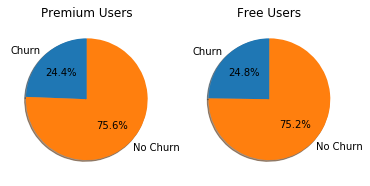

In [12]:
# Creates pie chart
len_free = len(free_churn)
len_premium = len(premium_churn)

sum_free = sum(free_churn['churned'])
sum_premium = sum(premium_churn['churned'])

labels = ['Churn', 'No Churn']
sizes_premium = [sum_premium/len_premium*100, (len_premium-sum_premium)/len_premium*100]
sizes_free = [sum_free/len_free*100, (len_free-sum_free)/len_free*100]

fig, ax = plt.subplots(1,2)
ax[0].pie(sizes_premium, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90);
ax[0].set_title('Premium Users')

ax[1].pie(sizes_free, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90);
ax[1].set_title('Free Users');


We see a slight variation between the two groups so we may or may not use this feature in the final model

#### Time Since Registration 

In [13]:
# Finds the latest event a user was a part of and collects the number of days since registration
# Interpreting this as the user accounts 'age'
latest_user_event = df.select('userId','ts').groupby('userId').agg(f.max(f.col('ts')).alias('ts'))
reg_latest = latest_user_event.join(df,on='ts').drop(latest_user_event.userId)
days_since_reg = reg_latest.select('userId','days_since_reg')

churned_time = churned.join(days_since_reg, on='userId').select('days_since_reg','churned').toPandas()

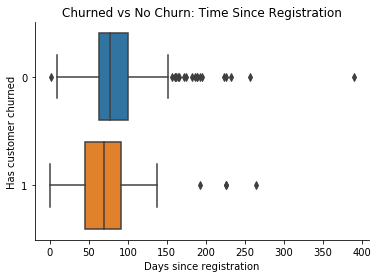

In [14]:
ax = sns.boxplot(data=churned_time, y='churned', x='days_since_reg', orient='h')
plt.xlabel('Days since registration')
plt.ylabel('Has customer churned')
plt.title('Churned vs No Churn: Time Since Registration')
sns.despine(ax=ax);

We can see that users who have not yet churned have a slightly longer lifetime. This intuitively makes sense but will most likely be a good feature to include in our final model. 

#### Variety of Artists Listened to

In [15]:
# Calculates the number of different artists that a user has listened to and splits the users
# by whether or not they have churned
n_artists = df.select('userId', 'artist').groupby('userId','artist') \
            .count().groupby('userId').count().selectExpr('userId', 'count as n_artists')

n_artists_churn = churned.join(n_artists, on='userId')
churned_user_artist = n_artists_churn.select('n_artists').where(f.col('churned') == 1).toPandas()
no_churn_user_artist = n_artists_churn.select('n_artists').where(f.col('churned') == 0).toPandas()

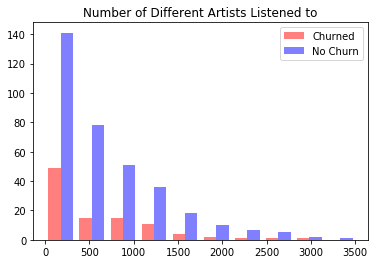

In [16]:
ax3 = plt.subplot()
ax3.hist([churned_user_artist['n_artists'], no_churn_user_artist['n_artists']], \
                 color=['r','b'], alpha=0.5);
ax3.set_title('Number of Different Artists Listened to');
ax3.legend(['Churned', 'No Churn']);

From the aggregate level we can see that users who listened to a large variety of artists were less likely to churn. This will definetley be a good feature to use in the final model. 

#### Average Length of Listening Session 

In [17]:
sessions = df.select('userId', 'sessionId').groupby('userId','sessionId').count()
avg_sessions = sessions.select('userId', 'count').groupby('userId') \
                .agg(f.round(f.avg(f.col('count')),0).alias('avgSessLen'))

sessions_churn = churned.join(avg_sessions, on='userId')
avg_sess_churn = sessions_churn.select('avgSessLen').where(f.col('churned') == 1).toPandas()
avg_sess_no_churn = sessions_churn.select('avgSessLen').where(f.col('churned') == 0).toPandas()

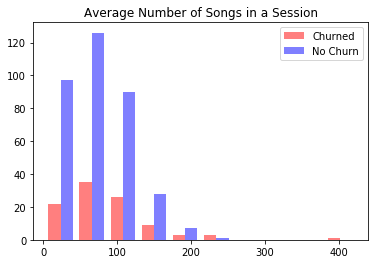

In [18]:
ax4 = plt.subplot()
ax4.hist([avg_sess_churn['avgSessLen'], avg_sess_no_churn['avgSessLen']], \
                  color=['r','b'], alpha=0.5);
ax4.legend(['Churned', 'No Churn']);
ax4.set_title('Average Number of Songs in a Session');

From the aggregate level we can see that users who listened to a larger average number of songs per session were less likely to churn. This will also definetley be a good feature to use in the final model

#### Number of Thumbs Up Given 

In [19]:
n_thumbs_up = df.select('userId', 'page').where(f.col('page') == 'Thumbs Up') \
                .groupby('userId').agg(f.count(f.col('page')).alias('numThumbs'))
thumbs_churn = churned.join(n_thumbs_up, on='userId')

churn_thumbs = thumbs_churn.select('numThumbs',).where(f.col('churned') == 1).toPandas()
no_churn_thumbs = thumbs_churn.select('numThumbs',).where(f.col('churned') == 0).toPandas()

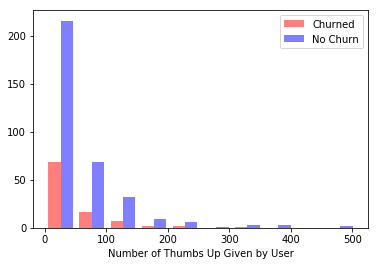

In [20]:
ax5= plt.subplot()
ax5.hist([churn_thumbs['numThumbs'], no_churn_thumbs['numThumbs']], \
                  color=['r','b'], alpha=0.5);
ax5.legend(['Churned', 'No Churn']);
ax5.set_xlabel('Number of Thumbs Up Given by User');

Its clear that users who give a large number of thumbs are less likely to churn. We will use this feature in our final model. 

# Feature Engineering

In [21]:
# Helpful dataframes
users = df.select('userId').distinct()
churned = df.select('userId', 'churned').groupby('userId') \
                .agg(f.sum(f.col('churned')).alias('churned'))

### Feature 1 - Status

##### Indicates whether or not a user is using the paid version or not

In [22]:
upgrades_downgrades = df.select('userId', 'page', 'ts') \
                        .where((df.page == 'Submit Upgrade') | (df.page=='Submit Downgrade'))

In [45]:
latest = upgrades_downgrades.groupby('userId').agg(f.max(f.col('ts')).alias('latest'))
latest_event = latest.join(upgrades_downgrades, on='userId')
determine_upgrade = f.udf(lambda x: 1 if x == 'Submit Upgrade' else 0, IntegerType())
user_status = latest_event.withColumn('status', determine_upgrade(latest_event.page)).select('userId', 'status')

### Feature 2 - Time since registration

##### Represents the amount of time since the user has registered

In [46]:
latest_user_event = df.select('userId','ts').groupby('userId').agg(f.max(f.col('ts')).alias('ts'))
reg_latest = latest_user_event.join(df,on='ts').drop(latest_user_event.userId)

In [47]:
days_since_reg = reg_latest.select('userId','days_since_reg').dropDuplicates(['userId'])

### Feature 3 - Number of 'Thumbs Up'

##### Represents the number of times a user has used the 'Thumbs Up' feature

In [48]:
n_thumbs_up = df.select('userId', 'page').where(f.col('page') == 'Thumbs Up') \
                .groupby('userId').agg(f.count(f.col('page')).alias('numThumbs'))

### Feature 4 - Average Songs Listened to in a Session

##### Represents the average number of songs that a user listened to in one session 

In [49]:
sessions = df.select('userId', 'sessionId').groupby('userId','sessionId').count()
avg_sessions = sessions.select('userId', 'count').groupby('userId') \
                .agg(f.round(f.avg(f.col('count')),0).alias('avgSessLen'))

### Feature 5 - Number of Different Artists Listened to

##### Represents the number of unique artists that a user has listened to

In [50]:
n_artists = df.select('userId', 'artist').groupby('userId','artist') \
            .count().groupby('userId').count().selectExpr('userId', 'count as n_artists')

### Feature 6 - Number of Songs Added to a Playlist

##### Represents the number of times a user added a song to a playlist

In [51]:
add_playlist = df.select('userId', 'page').where(f.col('page') == 'Add to Playlist')
n_songs = add_playlist.groupby('userId').count().selectExpr('userId','count as songs_added')

### Final DataFrame for Modeling

In [52]:
# Joins all of the individual features together
final_df = churned.join(user_status,on='userId') \
                  .join(days_since_reg,on='userId') \
                  .join(n_thumbs_up,on='userId') \
                  .join(avg_sessions,on='userId') \
                  .join(n_artists,on='userId') \
                  .join(n_songs, on='userId').dropDuplicates(['userId'])

In [53]:
#Puts the features in a vector format
numFeatures = ["status", "days_since_reg", "numThumbs",'avgSessLen', 'n_artists', 'songs_added']
assembler = VectorAssembler(inputCols= numFeatures, outputCol="NumFeatures")

vector_df= assembler.transform(final_df)

In [54]:
# Scales the data
scaler = StandardScaler(inputCol="NumFeatures", outputCol="NormNumFeatures")
scalerModel = scaler.fit(vector_df)
scale_df = scalerModel.transform(vector_df)

In [56]:
# Splits the data for training and testing
train, test = scale_df.randomSplit([.7, .3], seed=22)

### Naive Predictors

The naive predictors assume every user has either churned or not churned. It is something to compare our more advanced models to. 

In [58]:
# Assumes every one has churned
naive_model_1 = test.withColumn('prediction', f.lit(1.0))

In [59]:
evaluator = MulticlassClassificationEvaluator(labelCol="churned",predictionCol='prediction')
print('Test set metrics when we assume every user churned:')
print('Accuracy: {}'.format(evaluator.evaluate(naive_model_1, {evaluator.metricName: "accuracy"})))
print('F-1 Score:{}'.format(evaluator.evaluate(naive_model_1, {evaluator.metricName: "f1"})))

Test set metrics when we assume every user churned:
Accuracy: 0.2
F-1 Score:0.06666666666666667


In [60]:
# Assumes no one has churned
naive_model_0 = test.withColumn('prediction', f.lit(0.0))

In [61]:
evaluator = MulticlassClassificationEvaluator(labelCol="churned",predictionCol='prediction')
print('Test set metrics when assuming no user churned:')
print('Accuracy: {}'.format(evaluator.evaluate(naive_model_0, {evaluator.metricName: "accuracy"})))
print('F-1 Score:{}'.format(evaluator.evaluate(naive_model_0, {evaluator.metricName: "f1"})))

Test set metrics when assuming no user churned:
Accuracy: 0.8
F-1 Score:0.7111111111111111


#### Logistic Regression 

In [62]:
# Initialize classifier
LogReg = LogisticRegression(featuresCol = 'NormNumFeatures', labelCol = 'churned')

# Set evaluator to use F1 Score
f1_eval = MulticlassClassificationEvaluator(metricName='f1', labelCol = 'churned')

# Set up parameters for cross validation
paramGrid = ParamGridBuilder() \
    .addGrid(LogReg.maxIter,[5, 10]) \
    .addGrid(LogReg.regParam,[0.0,0.3]) \
    .build()

# Initialize CrossValidator object
cv_lr = CrossValidator(estimator=LogReg,
                          estimatorParamMaps=paramGrid,
                          evaluator=f1_eval,
                          numFolds=3)

In [ ]:
print('Training logistic regression classifier')
start = time()
best_lr = cv_lr.fit(train)
end = time()
print('The training process for Logistic Regression took {} seconds'.format(end - start))

Training logistic regression classifier
The training process for Logistic Regression took 768.3780760765076 seconds


In [77]:
start = time()

lr_train_results = best_lr.transform(train)
evaluator = MulticlassClassificationEvaluator(labelCol="churned",predictionCol='prediction')

print("Logistic Regression | Training Data")

print('Accuracy: {}'.format(evaluator.evaluate(lr_train_results, {evaluator.metricName: "accuracy"})))
print('F-1 Score:{}'.format(evaluator.evaluate(lr_train_results, {evaluator.metricName: "f1"})))

end = time()
print('The prediction process for Logistic Regression on training data took {} seconds'.format(end - start))

Logistic Regression | Training Data
Accuracy: 0.75
F-1 Score:0.6428571428571428
The prediction process for Logistic Regression on training data took 164.0537028312683 seconds


In [78]:
start = time()

lr_test_results = best_lr.transform(test)
evaluator = MulticlassClassificationEvaluator(labelCol="churned",predictionCol='prediction')

print("Logistic Regression | Testing Data")

print('Accuracy: {}'.format(evaluator.evaluate(lr_test_results, {evaluator.metricName: "accuracy"})))
print('F-1 Score:{}'.format(evaluator.evaluate(lr_test_results, {evaluator.metricName: "f1"})))

end = time()
print('The prediction process for Logistic Regression on testing data took {} seconds'.format(end - start))

Logistic Regression | Testing Data
Accuracy: 0.8142857142857143
F-1 Score:0.7434666666666666
The prediction process for Logistic Regression on testing data took 173.28186011314392 seconds


In [79]:
lr_best_maxIter = best_lr.bestModel.getOrDefault('maxIter')
lr_best_regParam = best_lr.bestModel.getOrDefault('regParam')
print("The value for maxIter in the best logistic regression model is: {}".format(lr_best_maxIter))
print("The value for regParam in the best logistic regression model is: {}".format(lr_best_regParam))

The value for maxIter in the best logistic regression model is: 10
The value for regParam in the best logistic regression model is: 0.0


### Decision Tree

In [ ]:
# Initialize DecisionTreeClassifier
dt = DecisionTreeClassifier(seed=42,featuresCol = 'NormNumFeatures', labelCol = 'churned')

# Set evaluator to use F1 Score
f1_eval = MulticlassClassificationEvaluator(metricName='f1', labelCol = 'churned')

# Set up parameters for cross validation
paramGrid = ParamGridBuilder() \
    .addGrid(dt.impurity,['entropy', 'gini']) \
    .addGrid(dt.maxDepth,[2, 3, 4, 5, 6, 7, 8]) \
    .build()

# Initialize CrossValidator object
cv_dt = CrossValidator(estimator=dt,
                          estimatorParamMaps=paramGrid,
                          evaluator=f1_eval,
                          numFolds=3)

In [ ]:
print('Training the decisison tree classifier')
start = time()
best_dt = cv_dt.fit(train)   
end = time()
print('The training process for Decision Tree took {} seconds'.format(end - start))

The training process for Decision Tree took 1278.6049432754517 seconds


In [ ]:
start = time()

dt_train_results = best_dt.transform(train)
evaluator = MulticlassClassificationEvaluator(labelCol="churned",predictionCol='prediction')

print("Decision Tree | Training Data")

print('Accuracy: {}'.format(evaluator.evaluate(dt_train_results, {evaluator.metricName: "accuracy"})))
print('F-1 Score:{}'.format(evaluator.evaluate(dt_train_results, {evaluator.metricName: "f1"})))

end = time()
print('The prediction process for Decision Tree on training data took {} seconds'.format(end - start))

Decision Tree | Training Data
Accuracy: 0.8081395348837209
F-1 Score:0.8021733938380702
The prediction process for Decision Tree on training data took 159.04235863685608 seconds


In [ ]:
start = time()

dt_test_results = best_dt.transform(test)
evaluator = MulticlassClassificationEvaluator(labelCol="churned",predictionCol='prediction')

print("Decision Tree | Testing Data")

print('Accuracy: {}'.format(evaluator.evaluate(dt_test_results, {evaluator.metricName: "accuracy"})))
print('F-1 Score:{}'.format(evaluator.evaluate(dt_test_results, {evaluator.metricName: "f1"})))

end = time()
print('The prediction process for Decision Tree on testing data took {} seconds'.format(end - start))

Decision Tree | Testing Data
Accuracy: 0.7714285714285715
F-1 Score:0.7714285714285715
The prediction process for Decision Tree on testing data took 179.54874277114868 seconds


In [ ]:
dt_best_impurity = best_dt.bestModel.getOrDefault('impurity')
dt_best_maxDepth = best_dt.bestModel.getOrDefault('maxDepth')
print("The value for impurity in the best decision tree model is: {}".format(dt_best_impurity))
print("The value for maxDepth in the best decision tree model is: {}".format(dt_best_maxDepth))

The value for impurity in the best decision tree model is: entropy
The value for maxDepth in the best decision tree model is: 2


### Gradient Boosted Trees

In [ ]:
# Initialize classifier
gbt = GBTClassifier(maxIter=10,seed=42,featuresCol = 'NormNumFeatures', labelCol = 'churned')

# Set evaluator to use F1 Score
f1_eval = MulticlassClassificationEvaluator(metricName='f1', labelCol = 'churned')

# Build paramGrid
paramGrid = ParamGridBuilder() \
    .addGrid(gbt.maxIter,[5,10]) \
    .addGrid(gbt.maxDepth,[10,15]) \
    .build()

# Initialize CrossValidator object
cv_gbt = CrossValidator(estimator=gbt,
                          estimatorParamMaps=paramGrid,
                          evaluator=f1_eval,
                          numFolds=3)

In [ ]:
print('Training the gradient boosted trees classifier')
start = time()
best_gbt = cv_gbt.fit(train)   
end = time()
print('The training process for GBT took {} seconds'.format(end - start))

Training the gradient boosted trees classifier
The training process for GBT took 2544.100419998169 seconds


In [ ]:
start = time()

gbt_train_results = best_gbt.transform(train)
evaluator = MulticlassClassificationEvaluator(labelCol="churned",predictionCol='prediction')

print("GBT | Training Data")

print('Accuracy: {}'.format(evaluator.evaluate(gbt_train_results,{evaluator.metricName: "accuracy"})))
print('F-1 Score:{}'.format(evaluator.evaluate(gbt_train_results, {evaluator.metricName: "f1"})))

end = time()
print('The prediction process for GBT on training data took {} seconds'.format(end - start))

GBT | Training Data
Accuracy: 1.0
F-1 Score:1.0
The prediction process for GBT on training data took 164.63793921470642 seconds


In [ ]:
start = time()

gbt_test_results = best_gbt.transform(test)
evaluator = MulticlassClassificationEvaluator(labelCol="churned",predictionCol='prediction')

print("GBT | Testing Data")

print('Accuracy: {}'.format(evaluator.evaluate(gbt_test_results, {evaluator.metricName: "accuracy"})))
print('F-1 Score:{}'.format(evaluator.evaluate(gbt_test_results, {evaluator.metricName: "f1"})))

end = time()
print('The prediction process for GBT on testing data took {} seconds'.format(end - start))

GBT | Testing Data
Accuracy: 0.7142857142857143
F-1 Score:0.7268518518518517
The prediction process for GBT on testing data took 164.6397180557251 seconds


In [ ]:
gbt_best_maxIter = best_gbt.bestModel.getOrDefault('maxIter')
gbt_best_maxDepth = best_gbt.bestModel.getOrDefault('maxDepth')
print("The value for maxIter in the best GBT model is: {}".format(gbt_best_maxIter))
print("The value for maxDepth in the best GBT model is: {}".format(gbt_best_maxDepth))

The value for maxIter in the best GBT model is: 5
The value for maxDepth in the best GBT model is: 10
